# M54 data 

Four our test with real data, we will use the globular cluster M54. Benefit of this object is that we have a good estimate of the ground truth. A comparison between the (age,metallicity) distributions from MAP estimates (using the PPXF software) and the ground truth is presented in [Boecker et al](https://ui.adsabs.harvard.edu/abs/2020ApJ...896...13B/abstract) (who also kindly provided this data).

The code has been updated to read in this data. Before running this, you will need:
1. `pip install spectres`
2. get the appropriate SSP models. To do this:
   - go to the [MILES site](http://research.iac.es/proyecto/miles/pages/webtools/tune-ssp-models.php)
   - in the 'Input parameters' section, choose 'E-MILES' in the drop down menu under 'SSP Models'
   - leave all other settings as default
   - click 'Submit Query'
   - a new page opens. Follow the link to the 'MILES FTP'
   - this should open a folder with several tarred data files. You want `EMILES_BASTI_BASE_BI_FITS.tar.gz`
   - unzip this into the location `uq4pk/data/EMILES_BASTI_BASE_BI_FITS`. This should contain 8904 files with names like `Ebi3.50Zp0.40T14.0000_iTp0.00_baseFe.fits`

## Look at the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uq4pk_src

m54_data = uq4pk_src.data.M54()
print(m54_data.y.shape)

m54_data.logarithmically_resample(dv=50.)
print(m54_data.y.shape)

(3361,)

Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 

(3800,)


The M54 data consists of a observed spectrum, noise level, and a mask. The regions with `mask==0` should be excluded from the fit as they are contaminated with sky spectra.

Text(0, 0.5, 'Mask [0=exclude]')

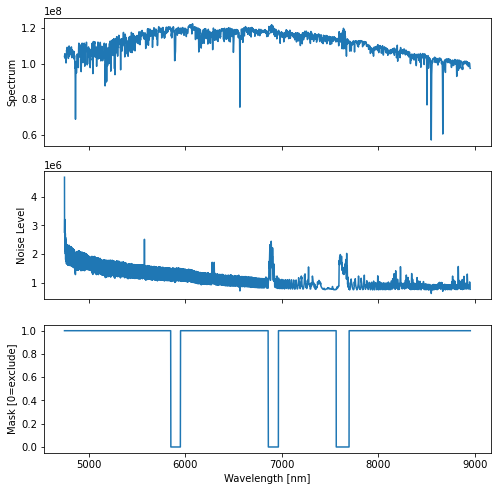

In [2]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8,8))
ax[0].plot(m54_data.lmd, m54_data.y)
ax[1].plot(m54_data.lmd, m54_data.noise_level)
ax[2].plot(m54_data.lmd, m54_data.mask)

ax[2].set_xlabel('Wavelength [nm]')
ax[0].set_ylabel('Spectrum')
ax[1].set_ylabel('Noise Level')
ax[2].set_ylabel('Mask [0=exclude]')

Additionally, we have estimates of age/metallicity distributiuons:

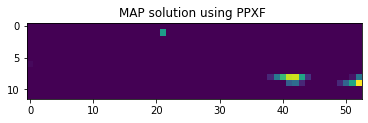

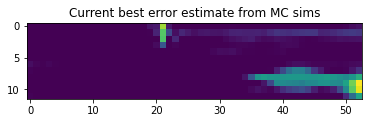

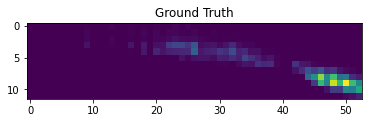

In [3]:
def orient_image(img):
    return np.flipud(img.T)

# MAP solutuon
img = m54_data.ppxf_map_solution
plt.imshow(orient_image(img))
plt.gca().set_title('MAP solution using PPXF ')
plt.show()

# current best error estimate
# 100 MAP solutions from monte carlo resampling of noise
img = np.std(m54_data.mcsims_map_weights, -1)
plt.imshow(orient_image(img))
plt.gca().set_title('Current best error estimate from MC sims')
plt.show()

# ground truth 
img = m54_data.ground_truth
plt.imshow(orient_image(img))
plt.gca().set_title('Ground Truth')
plt.show()

## SSP models

*Note*: the SSP models we need to fit this data are different to those we have been using previously (due to different wavelength ranges). To get the right models, follow the instructions above to get the data-files, which should then be read in as follows,

In [4]:
ssps = uq4pk_src.model_grids.MilesSSP(
    miles_mod_directory='EMILES_BASTI_BASE_BI_FITS',
    imf_string='Ebi1.30',
    lmd_min=None,
    lmd_max=None,
    )
ssps.resample_spectra(m54_data.lmd)
# normalise the SSP templates to be light-weighted rather than mass-weighted,
ssps.Xw /= np.sum(ssps.Xw, 0)
ssps.dv = m54_data.dv
ssps.speed_of_light = m54_data.speed_of_light

## Evaluating the observation operator

In [5]:
from uq4pk_src.observation_operator import ObservationOperator
G = ObservationOperator(ssps=ssps,
                        dv=ssps.dv,
                        do_log_resample=False)

Distribution functions should have shape (12, 53)


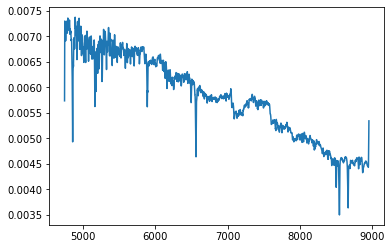

In [6]:
# example input parametrs
f = np.abs(np.random.uniform(size=(12,53)))
Theta_v = [50, 100, 1, 0, 0, 0.3, 0.1]

ybar = G.evaluate(f, Theta_v)

plt.plot(ssps.lmd, ybar, '-')

The jump seen at the start and end of this model spectrum are artifacts of performing a convolution using fourier transforms (which incorrectly assumes that the LOSVD is periodic).

To counter this, we can add the first and last pixels to the data mask,

In [7]:
npix_buffer_mask = 20
m54_data.mask[:npix_buffer_mask] = False
m54_data.mask[-npix_buffer_mask:] = False

### Re-creating the ppxf fit

In [8]:
from ppxf import ppxf

In [9]:
templates = ssps.Xw
galaxy = m54_data.y
noise = m54_data.noise_level
velscale = ssps.dv
start = [0., 30., 0., 0.]
bounds = [[-500,500], [3,300.], [-0.3,0.3], [-0.3,0.3]]
moments = 4
mask = m54_data.mask

# final pixel is NAN, breaks PPXF even though this is masked, so remove it here manually
templates = templates[:-1,:]
galaxy = galaxy[:-1]
noise = noise[:-1]
mask = mask[:-1]

ppxf_fit = ppxf.ppxf(
    templates, 
    galaxy, 
    noise, 
    velscale,
    start=start,
    degree=8,
    moments=moments,
    bounds=bounds,
    regul=0,
    mask=mask    
)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       145        30     0.016    -0.300
chi2/DOF: 1.962; degree = 8; mdegree = 0
method = capfit; Jac calls: 10; Func calls: 56; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  5 / 636


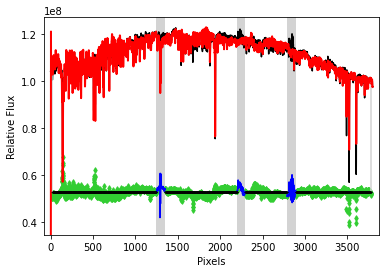

In [10]:
ppxf_fit.plot()

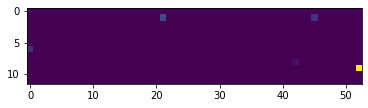

In [12]:
img = np.reshape(ppxf_fit.weights, ssps.par_dims).T
plt.imshow(orient_image(img))

## Different ObservationOperators ?

The PPFX reconstruction, when put through our observation operator, does not reproduce the data. Why?

PPXF models more effects more than our observation operator does, to treat known systematics. One such effect is distortions to the shape of the spectral continuum, caused by inadequacies in data-reduction and/or by the effect of dust-absorption. This can be treated in PPXF by setting the following parameter (from ppxf docs):

```
mdegree:
Degree of the multiplicative Legendre polynomial (with a mean of 1) used to correct the continuum shape during the fit (default: 0). The zero degree multiplicative polynomial is always included in the fit as it corresponds to the weights assigned to the templates. Note that the computation time is longer with multiplicative polynomials than with the same number of additive polynomials.
```

From the Boeker et al paper, they say they make the following choices for `mdegree`:

```
Solely multiplicative polynomials are used to correct for any continuum mismatch between the SSP models and the observed spectrum. Their degree is determined according to $[(\lambda_\mathrm{max}-\lambda_\mathrm{min})/200 Å]$ ,ensuring that spectral features narrower than 200 Å are not influenced by the polynomial
```

*Solely multiplicative* implies that no additive polynomial is used, which requires the `degree=-1` to be set. The precise numberical value of `mdegree` which has been used is unclear from that description, but it > 0. Let's try `mdegree=10`. Redoing the PPXF fit with these two parameters set:

In [13]:
ppxf_fit_mdegree = ppxf.ppxf(
    templates, 
    galaxy, 
    noise, 
    velscale,
    start=start,
    degree=-1,
    mdegree=10,
    moments=moments,
    bounds=bounds,
    regul=0,
    mask=mask    
)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       146         3    -0.008    -0.003
chi2/DOF: 1.143; degree = -1; mdegree = 10
method = capfit; Jac calls: 9; Func calls: 139; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 636


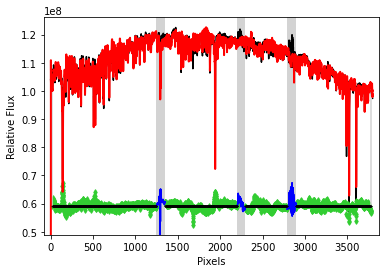

In [14]:
ppxf_fit_mdegree.plot()

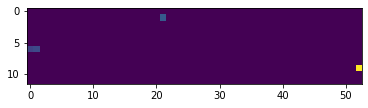

In [15]:
img = np.reshape(ppxf_fit_mdegree.weights, ssps.par_dims).T
plt.imshow(orient_image(img))

We can plot the bestfitting polynomial function which PPXF has found is needed to correct the shape of the spectral continum.

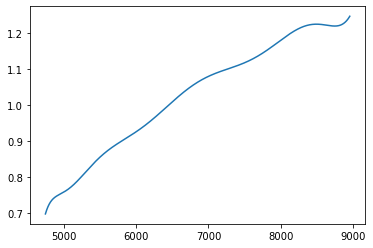

In [16]:
lmd = np.exp(ssps.w[:-1])
plt.plot(lmd, ppxf_fit_mdegree.mpoly)

The `mdegree=10` polynomial coefficients are free parameters which have been optimised by the fit. The best fit values which have been found are,

In [17]:
ppxf_fit_mdegree.mpolyweights

array([ 0.27528962, -0.0209337 , -0.01079055, -0.00259699, -0.00535378,
       -0.00957602, -0.01037294,  0.0041587 ,  0.02603837,  0.0018896 ])

These are weights for Legendre polynomials. The resulting polynomial can be evaluated as,

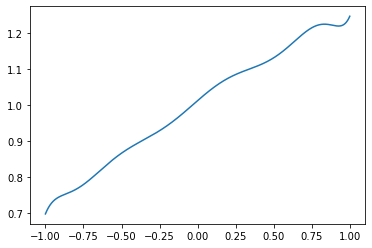

In [18]:
from numpy.polynomial import legendre
x = np.linspace(-1, 1, len(galaxy))
y = legendre.legval(x, np.append(1, ppxf_fit_mdegree.mpolyweights))
plt.plot(x, y)

### How to proceed?

The aim of our initial exercise was to demonstrate an improved method for UQ for our problem. We had hoped that tests using idealised mock data (unaffected by real data systematics) would be enough to demonstrate this.

Real data however, unfortuneately suffers from the continuum distortion systematic. So to proceed with real data, our options are either:
1. update our observation operator to handle continuum distortion. This could be using the same approach as PPXF, i.e. multiplication by a legendre polynomial. It could, however, suffice to have just use a linear function, which would caputure the majority of the effect and only intoduce one new parameter to the fit.
2. *NOT* update our observation operator, but instead we could *correct* the templates by the continuum distortion found by PPXF, i.e.

For now we will go for option 2.

To correct the templates using the continuum distortion found by PPXF, do the following:

In [19]:
continuum_distorition = ppxf_fit_mdegree.mpoly
# add an extra element to the end of array to account for one that we chopped off earlier
continuum_distorition = np.concatenate([continuum_distorition, [continuum_distorition[-1]]])

import copy
ssps_corrected = copy.deepcopy(ssps)
ssps_corrected.Xw = (ssps_corrected.Xw.T * continuum_distorition).T

Now to modify the observation operator we relpace the ssps by these "corrected" versions,

In [20]:
G = ObservationOperator(ssps=ssps_corrected,
                        dv=ssps_corrected.dv,
                        do_log_resample=False)

Distribution functions should have shape (12, 53)


Let's check this is correct - let's redo the ppxf fit with these rescaled templates, setting `mdegree=-1`. This should produce the same output the previous ppxf fit with the original templates and `mdegree=10`:

In [32]:
templates = ssps_corrected.Xw
galaxy = m54_data.y
noise = m54_data.noise_level
velscale = ssps.dv
start = [0., 30., 0., 0.]
bounds = [[-500,500], [3,300.], [-0.3,0.3], [-0.3,0.3]]
moments = 4
mask = m54_data.mask

# final pixel is NAN, breaks PPXF even though this is masked, so remove it here manually
templates = templates[:-1,:]
galaxy = galaxy[:-1]
noise = noise[:-1]
mask = mask[:-1]

ppxf_fit_mdegree = ppxf.ppxf(
    templates,
    galaxy,
    noise,
    velscale,
    start=start,
    degree=-1,
    mdegree=-1,
    moments=moments,
    bounds=bounds,
    regul=0,
    mask=mask
)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       146         3     0.002    -0.005
chi2/DOF: 1.140; degree = -1; mdegree = 0
method = capfit; Jac calls: 8; Func calls: 45; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 636


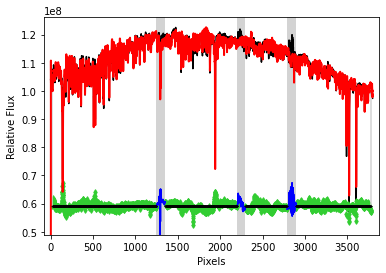

In [39]:
ppxf_fit_mdegree.plot()

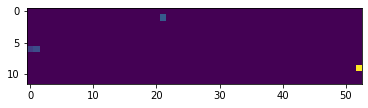

In [40]:
f_ppxf_new = orient_image(np.reshape(ppxf_fit_mdegree.weights, ssps.par_dims).T)
plt.imshow(f_ppxf_new)


Testing the new observation operator
-----------------------------------

Let us check whether the improved observation operator leads to a better data-fit.

We don't fit $\theta_v$, but set it equal to the PPXF-best fit.

In [21]:
theta_v = np.array([146, 3, 1., 0., 0., -0.008, -0.003])

In [22]:
mask = m54_data.mask
y = m54_data.y[mask]
y_sd = m54_data.noise_level[mask]
G_old = ObservationOperator(ssps=ssps, dv=ssps.dv, do_log_resample=False)
f_ppxf = np.reshape(ppxf_fit_mdegree.weights, ssps.par_dims).T
f_ppxf = orient_image(f_ppxf)

y_hat_old = G_old.evaluate(f_ppxf, theta_v)[mask]
y_hat_new = G.evaluate(f_ppxf, theta_v)[mask]
data_fit_old = np.linalg.norm((y - y_hat_old) / y_sd)
data_fit_new = np.linalg.norm((y - y_hat_new) / y_sd)

print(f"Data fit without correction: {data_fit_old}.")
print(f"Data fit with correction: {data_fit_new}.")

Distribution functions should have shape (12, 53)
Data fit without correction: 6035.450427394506.
Data fit with correction: 6021.22252411808.


So, the corrected observation operator leads to a *better* data fit of the PPXF solution
than the old one. That's good.

Let us compare with our MAP estimate.
For this, we first normalize our data. As a baseline, I am using the PPXF MAP solution
from the M54 data:

In [23]:
f_ppxf = orient_image(m54_data.ppxf_map_solution)

f_ppxf_norm = f_ppxf / np.sum(f_ppxf)
y_ref = G_old.evaluate(f_ppxf_norm, theta_v)
# compute a scaling factor such that ||y_ref|| = ||y||
s = np.linalg.norm(y_ref) / np.linalg.norm(y)
# rescale data and noise
y_norm = y.copy()
y_norm *= s
y_sd_norm = y_sd.copy()
y_sd_norm *= s


First, we fit our model, using the **old, uncorrected** observation operator.

Distribution functions should have shape (12, 53)




Starting the constrained Gauss-Newton method. Cost at starting value: 407.3290363671375
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
| Iteration | Cost                    | Constraint violation    | Stepsize (||p||)        | Steplength (h)          | Computation time [s]    |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     1     |    8.322789909967371    |   9.25868323513393e-16  |   0.18969234346006517   |           1.0           |    1.1787889003753662   |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     2     |     8.32278990996737    |  1.607

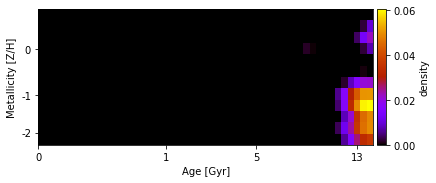

In [25]:
%matplotlib inline
from uq4pk_fit.inference import StatModel, ForwardOperator
from uq4pk_fit.visualization import plot_distribution_function

# Initialize ForwardOperator object
forward_operator_old = ForwardOperator(hermite_order=4, mask=mask, ssps=ssps, dv=ssps.dv, do_log_resample=False)
# Fit the model
model_old = StatModel(y=y_norm, y_sd=y_sd_norm, forward_operator=forward_operator_old)
model_old.fix_theta_v(indices=np.arange(model_old.dim_theta), values=theta_v)
model_old.normalize()
fitted_model_old = model_old.fit()
f_map_old = fitted_model_old.f_map
plot_distribution_function(image=f_map_old, ssps=ssps, show=True)

Next, fit our model using the **corrected** observation operator.

Distribution functions should have shape (12, 53)




Starting the constrained Gauss-Newton method. Cost at starting value: 289.87355469110963
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
| Iteration | Cost                    | Constraint violation    | Stepsize (||p||)        | Steplength (h)          | Computation time [s]    |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     1     |    1.257147413045157    |  3.041095068914884e-15  |   0.11807512880394096   |           1.0           |    1.0267162322998047   |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     2     |    1.2571474130451568   |  3.15

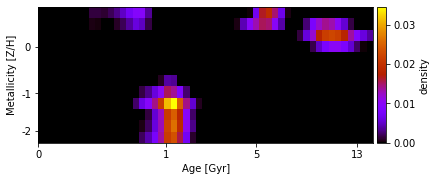

In [26]:
forward_operator = ForwardOperator(hermite_order=4, mask=mask, ssps=ssps_corrected, dv=ssps_corrected.dv,
                                   do_log_resample=False)
# Fit the model
model = StatModel(y=y_norm, y_sd=y_sd_norm, forward_operator=forward_operator)
model.fix_theta_v(indices=np.arange(model.dim_theta), values=theta_v)
model.normalize()
fitted_model = model.fit()
f_map = fitted_model.f_map
plot_distribution_function(image=f_map, ssps=ssps_corrected)

Let us look at the ground truth.

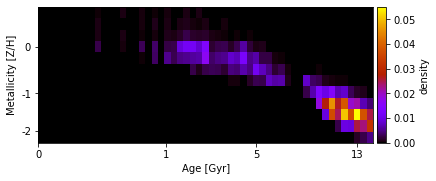

In [27]:
f_gt = m54_data.ground_truth
f_gt = orient_image(f_gt)
f_gt_normalized = f_gt / np.sum(f_gt)
plot_distribution_function(image=f_gt_normalized, ssps=ssps)

Both of the MAP estimates do not really look like this.

What do the numbers say? Let us evaluate the data fit.

In [28]:
# Compute data fit
ydim = y_norm.size

def data_fit(z):
    scaled_fit = np.linalg.norm((z - y_norm) / y_sd_norm) / ydim
    return scaled_fit

y_map_old = G_old.evaluate(f_map_old, theta_v)[mask]
y_map_old_new = G.evaluate(f_map_old, theta_v)[mask]
y_map = G.evaluate(f_map, theta_v)[mask]
y_ppxf = G.evaluate(f_ppxf_norm, theta_v)[mask]
y_gt = G.evaluate(f_gt_normalized, theta_v)[mask]
data_fit_map_old = data_fit(y_map_old)
data_fit_map_old_new = data_fit(y_map_old_new)
data_fit_map = data_fit(y_map)
data_fit_ppxf = data_fit(y_ppxf)
data_fit_gt = data_fit(y_gt)
print(f"Data fit of MAP, old: {data_fit_map_old}")
print(f"Data fit of old MAP with new operator: {data_fit_map_old_new}")
print(f"Data fit of MAP, corrected: {data_fit_map}")
print(f"Data fit of PPXF: {data_fit_ppxf}")
print(f"Data fit of ground truth: {data_fit_gt}")

Data fit of MAP, old: 0.06889769310568147
Data fit of old MAP with new operator: 0.260008107625136
Data fit of MAP, corrected: 0.026153552485380864
Data fit of PPXF: 0.2123518265200491
Data fit of ground truth: 0.1971525180045559


Let us summarize:

- The best data fit is achieved by the MAP estimate that was computed using the
 corrected observation operator.
- If we compute the MAP estimate using the old observation operator and put
this into the old observation operator, then this fits the data better than the PPXF fit
and the ground truth.
- However, if we take the MAP estimate that was computed using the old observation operator
and put this into the corrected operator, then the result has the poorest data fit.

From these observations, I would make the following guess:

- The corrected observation operator improves the reconstruction, as it leads
to a better data fit of the MAP estimate.
- However, this improvement is insufficient to rectify the discrepancy between
our MAP estimate and the PPXF fit and ground truth

The fact that the data fit of our MAP estimate is much smaller than the data fit
of the ground truth might be interpreted as overfitting, but increasing the
regularization does not lead to an improved reconstruction:



Starting the constrained Gauss-Newton method. Cost at starting value: 297.33424744414145
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
| Iteration | Cost                    | Constraint violation    | Stepsize (||p||)        | Steplength (h)          | Computation time [s]    |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     1     |    12.94504370241638    |  2.220446049250313e-16  |   0.022601012876584226  |           1.0           |   0.17567229270935059   |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     2     |    12.945043702416378   |  1.11

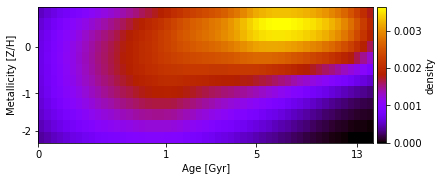

Data fit with more regularization: 0.045376927742492836


In [29]:
model.beta1 = 1e9
fitted_model_regularized = model.fit()

f_map_regularized = fitted_model_regularized.f_map
plot_distribution_function(f_map_regularized, ssps=ssps_corrected)

y_map_regularized = G.evaluate(f_map_regularized, theta_v)[mask]
data_fit_map_regularized = data_fit(y_map_regularized)

print(f"Data fit with more regularization: {data_fit_map_regularized}")

The fact that this obviously over-regularized solution achieves a better
data fit than the PPXF solution with respect to the corrected observation operator might indicate
that our operator is still significantly different from the one used in PPXF.